# Extra - AutoEncoders com MLP

Iremos replicar o que vimos no notebook da parte prática, porém, desta vez, utilizando redes _fully connected_ (MLPs) para a tarefa de reconstrução dos dados do MNIST.

Além disso, iremos explorar 3 desafios, sendo eles:
1. **Análise de um espaço latente via algoritmos de _clusterização_**, tipicamente utilizado quando queremos realizar uma anotação automática em uma abordagem semi-supervisionada ou durante a exploração de dados utilizando AutoEncoders como forma de agrupamento de dados.

2. **Geração de imagens a partir de pontos do espaço latente** (veremos que isso é mais fácil de se fazer e condicionar em Variational AutoEncoders e matérias subsequentes).
   
4. **"Desembaraçamento" (_disentanglement_) do espaço latente** via tarefas auxiliares como classificação, tornando o treinamento entre um misto de classificação a partir do espaço latente e reconstrução da imagem de entrada.

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.v2 as T 

from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torchsummary import summary
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
# Por questões de reproducibilidade, iremos fixar algumas sementes aleatórias.
# Caso queira rodar os códigos e obter outros resultados, comente essa célula de código.

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Carregamento e visualização dos dados

In [3]:
mnist_datapath = '/pgeoprj2/ciag2024/dados/'

transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True)
])

train_dataset = MNIST(
    mnist_datapath,
    train=True,
    transform=transforms,
    download=False
)

test_dataset = MNIST(
    mnist_datapath,
    train=False,
    transform=transforms,
    download=False
)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

Train dataset size: 60000
Test dataset size: 10000


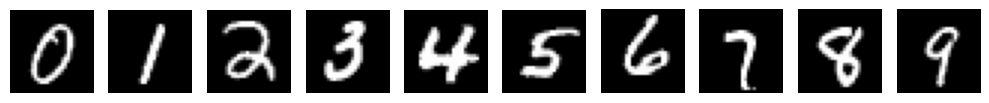

In [4]:
fig, axs = plt.subplots(1, 10, figsize=(10, 4))

for i in range (0, 10):
    # Obtendo um índice aleatório de um dado da classe "i"
    label_idx = torch.where(train_dataset.targets == i)[0]
    random_idx = torch.randint(len(label_idx), size=(1,)).item()

    # Obtendo o dado da classe
    sample_idx = label_idx[random_idx]
    image, _ = train_dataset[sample_idx]

    axs[i].axis('off')
    axs[i].imshow(image.squeeze(), cmap='gray')
    
fig.tight_layout()

## Definindo a arquitetura

Como simplificação, iremos trabalhar com um AutoEncoder denso, isto é formado por MLPs.

Para o caso de imagens simples, e pequenas, como é o caso do MNIST, observamos uma performance equiparável entre AutoEncoders densos e convolucionais. Porém, tenha sempre em mente que o número de parâmetros dessa abordagem é bem maior do que a abordagem convolucional.

In [5]:
class AutoEncoderMLP(nn.Module):
    def __init__(self, img_size: int = 28):
        super().__init__()

        # Uma imagem do MNIST será 1 x 28 x 28
        num_features = 1 * img_size * img_size

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # nosso espaço latente estará em R²
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, num_features),  # recuperando as dimensões da imagem original
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))  # revertendo o flatten (784, ) -> (1, 28, 28)
        )

    def forward(self, x):
        latent = self.encoder(x)
        outputs = self.decoder(latent)

        return outputs, latent

In [6]:
model = AutoEncoderMLP(img_size=28)
model = model.to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 2]             130
            Linear-7                   [-1, 64]             192
              ReLU-8                   [-1, 64]               0
            Linear-9                  [-1, 128]           8,320
             ReLU-10                  [-1, 128]               0
           Linear-11                  [-1, 784]         101,136
        Unflatten-12            [-1, 1, 28, 28]               0
Total params: 218,514
Trainable params: 218,514
Non-trainable params: 0
-------------------------------

## Treinamento do modelo

In [7]:
def train(model, optimizer, loss_fn, train_loader, val_loader=None, epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for i, (inputs, _) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs = inputs.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs, _ = model(inputs)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            loss = loss_fn(outputs, inputs)
            loss /= inputs.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss/(i+1):.4f}")

        train_loss /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for inputs, _ in val_loader:
                    inputs = inputs.to(device)

                    outputs, _ = model(inputs)
                    loss = loss_fn(outputs, inputs)
                    loss /= inputs.size(0)

                    val_loss += loss.item()

            val_loss /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}")

In [8]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print('Number of batches in train:', len(train_dataloader))
print('Number of batches in test:', len(test_dataloader))

Number of batches in train: 469
Number of batches in test: 79


Note que usaremos uma loss MSE (_Mean Squared Error_) com `reduction = 'sum'`, significando que iremos agregar o tensor de loss (uma perda por pixel da imagem) via soma. Isso é particularmente útil nesse caso onde a imagem reconstruída possui muitos 0s, evitando que a rede caia em um mínimo local enviesado em prever uma imagem completamente preta ou que possui um borrão no centro.

In [9]:
# Redefinindo o modelo por praticidade
model = AutoEncoderMLP(img_size=28)
model = model.to(device)

criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 20
train(model, optimizer, criterion, train_dataloader, test_dataloader, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: Train Loss: 42.9099 | Val Loss: 37.3291


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: Train Loss: 36.1991 | Val Loss: 35.0272


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: Train Loss: 34.4504 | Val Loss: 34.0129


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: Train Loss: 33.3559 | Val Loss: 32.8739


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: Train Loss: 32.4671 | Val Loss: 32.2849


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: Train Loss: 31.8548 | Val Loss: 31.7083


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: Train Loss: 31.3788 | Val Loss: 31.3597


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: Train Loss: 31.0385 | Val Loss: 31.2766


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: Train Loss: 30.7532 | Val Loss: 30.9624


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: Train Loss: 30.4954 | Val Loss: 30.6742


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: Train Loss: 30.2866 | Val Loss: 30.4598


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: Train Loss: 30.0799 | Val Loss: 30.3583


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: Train Loss: 29.9021 | Val Loss: 30.2715


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: Train Loss: 29.7878 | Val Loss: 30.1057


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: Train Loss: 29.6363 | Val Loss: 29.9322


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: Train Loss: 29.4906 | Val Loss: 29.9187


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: Train Loss: 29.4135 | Val Loss: 29.7473


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: Train Loss: 29.2820 | Val Loss: 29.6719


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: Train Loss: 29.1814 | Val Loss: 29.6679


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: Train Loss: 29.0931 | Val Loss: 29.5726


## Análise da reconstrução

Aqui devemos fazer um `unsqueeze` ao carregar as imagens dado que estamos utilizando o objeto _dataset_, que não retorna o dado com o _batch size_ como o _dataloader_. Dessa forma, adicionamos manualmente a dimensão de _batch size_ e também a removemos através do `squeeze` para fins de visualização.

In [11]:
def plot_reconstructions(model, dataset, n=8, figsize=(12, 6)):
    fig, axes = plt.subplots(2, n, figsize=figsize)
    images = torch.cat([dataset[i][0].unsqueeze(0) for i in range(n)], dim=0).to(device)

    model.eval()
    with torch.no_grad():
        reconstructions, *_ = model(images)  # *_ significa que iremos descartar todas as saídas a partir daquela

    for i, (ax, im, rec) in enumerate(zip(range(n), images, reconstructions)):
        im = im.cpu().squeeze()
        rec = rec.cpu().squeeze()

        axes[0][ax].imshow(im, cmap="gray")
        axes[0][ax].axis("off")
        axes[1][ax].imshow(rec, cmap="gray")
        axes[1][ax].axis("off")

        if i == n//2:
            axes[0][ax].set_title("Sample")
            axes[1][ax].set_title("Reconstruction")

    plt.tight_layout()
    plt.show()

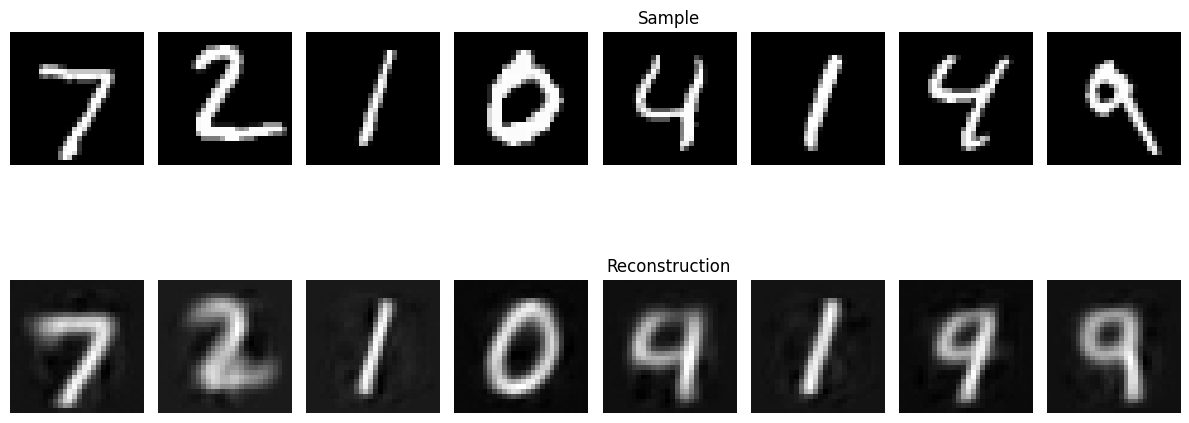

In [12]:
plot_reconstructions(model, test_dataset, n=8)

## Análise do espaço latente em dados de teste

In [13]:
def get_latent_representations(encoder, dataloader):
    labels_agg = []
    latent_representations = []
    
    encoder.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            latent_vectors = encoder(images)
            latent_representations.append(latent_vectors.cpu().numpy())
            labels_agg.append(labels.numpy())
    
    # Concatenate all latent representations
    latent_representations = np.concatenate(latent_representations, axis=0)
    labels_agg = np.concatenate(labels_agg, axis=0)

    return latent_representations, labels_agg


def plot_latent_space(encoder, dataloader, reduce_dims: str = None, plot_griddots: bool = False, title: str = None):
    latent_representations, labels_agg = get_latent_representations(encoder, dataloader)

    if reduce_dims is not None:
        if reduce_dims == 'pca':
            pca = PCA(n_components=2, random_state=42)
            latent_representations = pca.fit_transform(latent_representations)
        elif reduce_dims == 'tsne':
            tsne = TSNE(n_components=2, random_state=42)
            latent_representations = tsne.fit_transform(latent_representations)

    # Plot the latent representations
    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap('jet', 10)
    
    for c in range(10):
        indices = np.where(labels_agg == c)
        plt.scatter(
            latent_representations[indices, 0],
            latent_representations[indices, 1],
            s=3,
            label=f"{c}",
            c=[cmap(c)],
            alpha=0.5,
        )

    # Scatter plot linear space (discretization of latent space)
    if plot_griddots:
        latent1_range = np.linspace(0.9 * latent_representations[:, 0].min(), 0.9 * latent_representations[:, 0].max(), num=10)
        latent2_range = np.linspace(0.9 * latent_representations[:, 1].min(), 0.9 * latent_representations[:, 1].max(), num=10)

        xs, ys = np.meshgrid(latent1_range, latent2_range)
        plt.scatter(xs, ys, marker='*', c='black')
    
    # Add the labels mapping
    plt.legend(markerscale=5)

    if title is not None:
        plt.title(title)
        
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)

    plt.show()

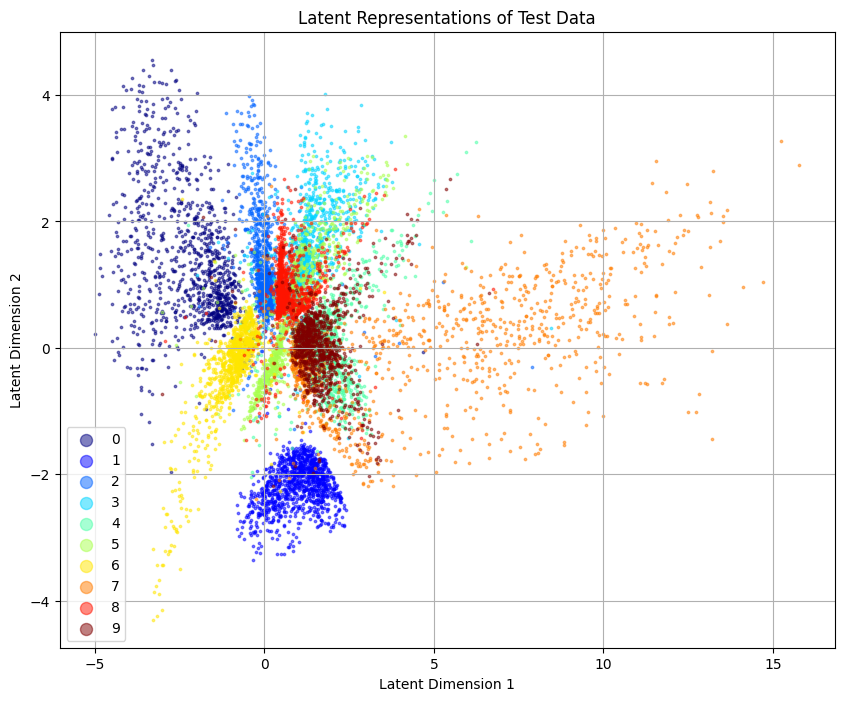

In [14]:
plot_latent_space(model.encoder, test_dataloader, title='Latent Representations of Test Data')

## **Desafio 1:** clusterização do espaço latente

No caso do MNIST, sempre teremos um par `(imagem, rótulo)`. Porém, em casos reais, AutoEncoders (e outras técnicas de aprendizado não-supervisionado) são usados para agrupar os dados e facilitar, por exemplo, a rotulação de alguns grupos de dados.

Podemos usar algoritmos de [_clustering_](https://scikit-learn.org/stable/modules/clustering.html) do `sklearn`, como KMeans, HDBScan, entre outros, para nos auxiliar a encontrar tais agrupamentos no nosso espaço latente. Como simplificação, usaremos o algoritmo do KMeans para encontrar esses grupos.

<div>
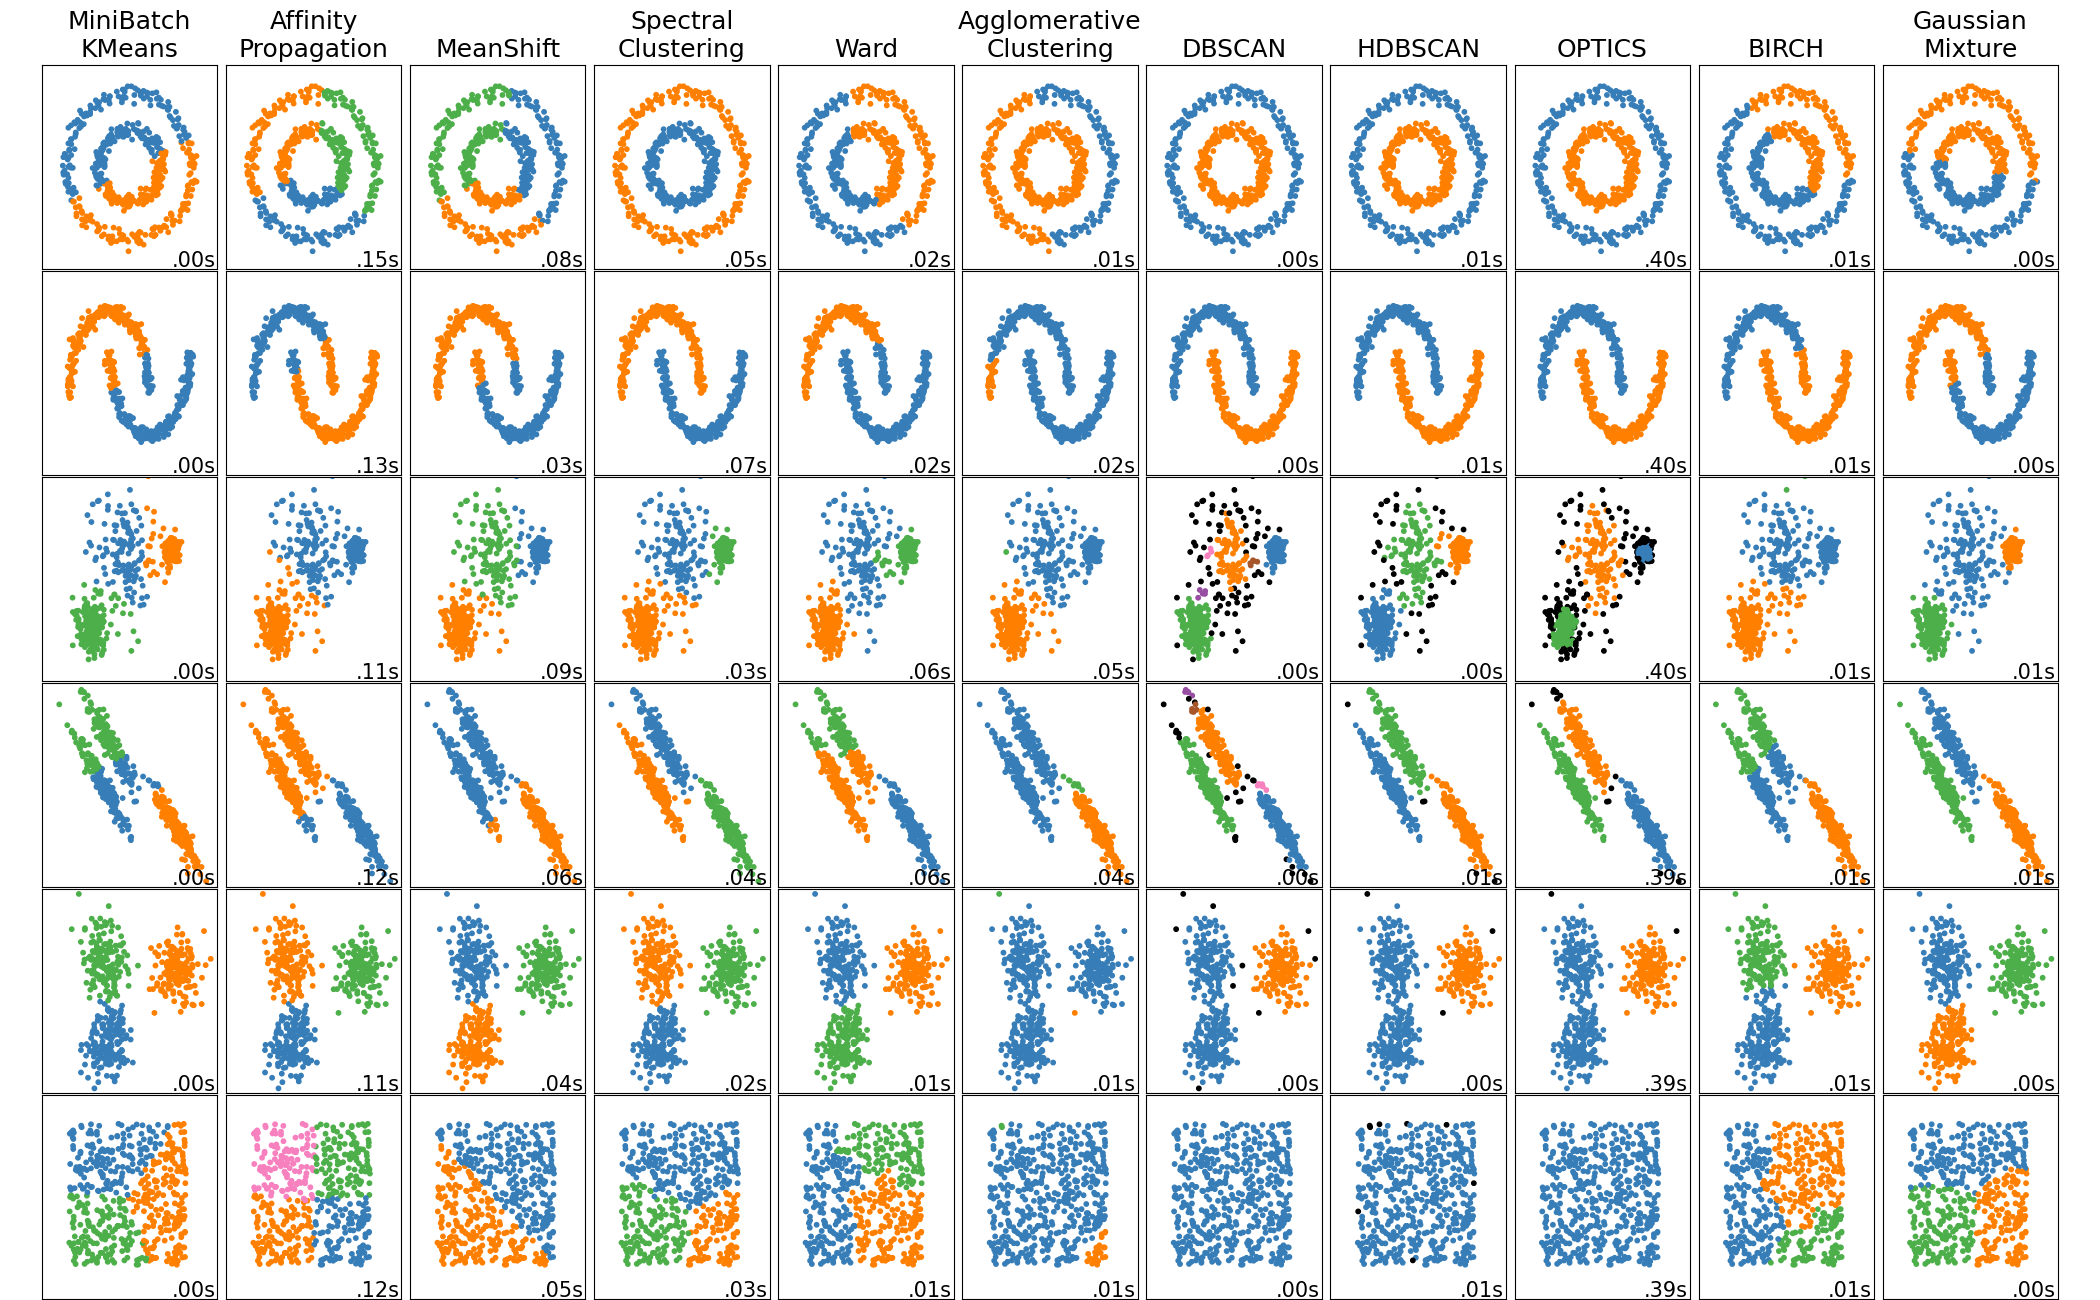
</div>

In [15]:
labels_agg = []
latent_representations = []

model.encoder.eval()
with torch.no_grad():
    for images, labels in train_dataloader:
        images = images.to(device)
        latent_vectors = model.encoder(images)
        latent_representations.append(latent_vectors.cpu().numpy())
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations = np.concatenate(latent_representations, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

print('Latent representations shape:', latent_representations.shape)
print('Labels shape:', labels_agg.shape)

Latent representations shape: (60000, 2)
Labels shape: (60000,)


In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10).fit(latent_representations)

# KMeans possui uma variável "labels_" que armazena o grupo associado com cada uma das nossas instâncias
clustering_groups = kmeans.labels_
clustering_groups

array([0, 5, 0, ..., 0, 6, 8], dtype=int32)

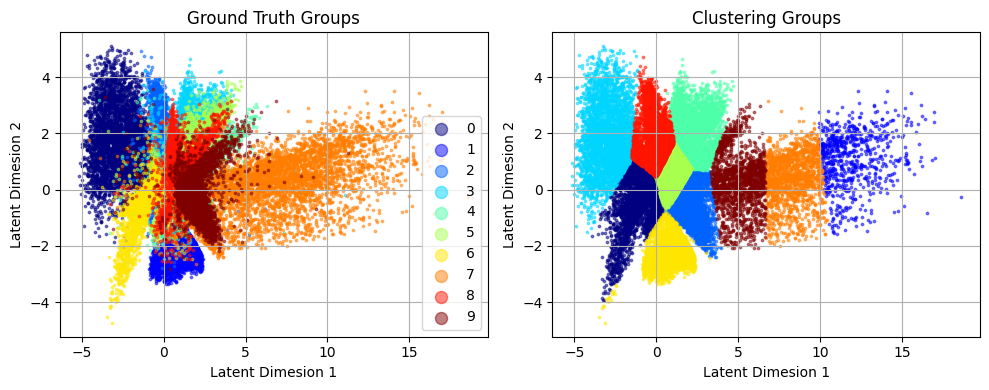

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
cmap = plt.get_cmap('jet', 10)

for c in range(10):
    indices = np.where(labels_agg == c)
    axs[0].scatter(
        latent_representations[indices, 0],
        latent_representations[indices, 1],
        s=3,
        label=f"{c}",
            c=[cmap(c)],
            alpha=0.5,
        )

    indices = np.where(clustering_groups == c)
    axs[1].scatter(
        latent_representations[indices, 0],
        latent_representations[indices, 1],
        s=3,
        label=f"{c}",
            c=[cmap(c)],
            alpha=0.5,
        )
    
# add the labels mapping
axs[0].set_title('Ground Truth Groups')
axs[1].set_title('Clustering Groups')

axs[0].legend(markerscale=5)

for i in range(2):
    axs[i].set_xlabel('Latent Dimesion 1')
    axs[i].set_ylabel('Latent Dimesion 2')
    axs[i].grid(True)

fig.tight_layout()

Algo interessante de se notar acima é a separação de grupos como os 1s em vários subgrupos pelo KMeans. O algoritmo de KMeans é inteiramente baseado em distâncias, por isso que em alguns grupos teremos a mistura de alguns dígitos e também a presença de grupos redundantes. Durante a análise manual de cada grupo, como por exemplo através da visualização de qual imagem pertence ao par `(latent1, latent2)`, podemos refinar esse agrupamento e, posteriormente, uma rotulação do grupo para uma tarefa supervisionada.

Devido a posição espacial ser considerada no KMeans, é uma boa prática normalizar as dimensões do nosso dado, nesse caso `(latent1, latent2)`. Porém, por simplificação, e também por não ter uma discrepância muito grande, deixamos isso de lado durante essa análise.

> Perceba que na análise acima estamos utilizando os dados de **treino**. Podemos executar a mesma análise no conjunto de teste, porém, para manter consistente a ideia de que não usamos o conjunto de teste durante algumas análises, optamos por usar o conjunto de treino nesse exemplo.

## **Desafio 2:** geração de imagens a partir do espaço latente

Tipicamente, ao treinar um AutoEncoder, estaremos interessados na utilidade do _encoder_ ou _decoder_. Enquanto que o _encoder_ pode ser usado para as análises vistas anteriormente, o _decoder_ já é utilizado para a geração de números do MNIST a partir do espaço latente. Tal geração será feita a partir de uma amostragem de valores `(latent1, latent2)`do nosso espaço latente.

> **Importante:** Durante esse desafio, iremos utilizar o espaço latente do conjunto de teste, por ter menos amostras e ser mais fácil de trabalhar.

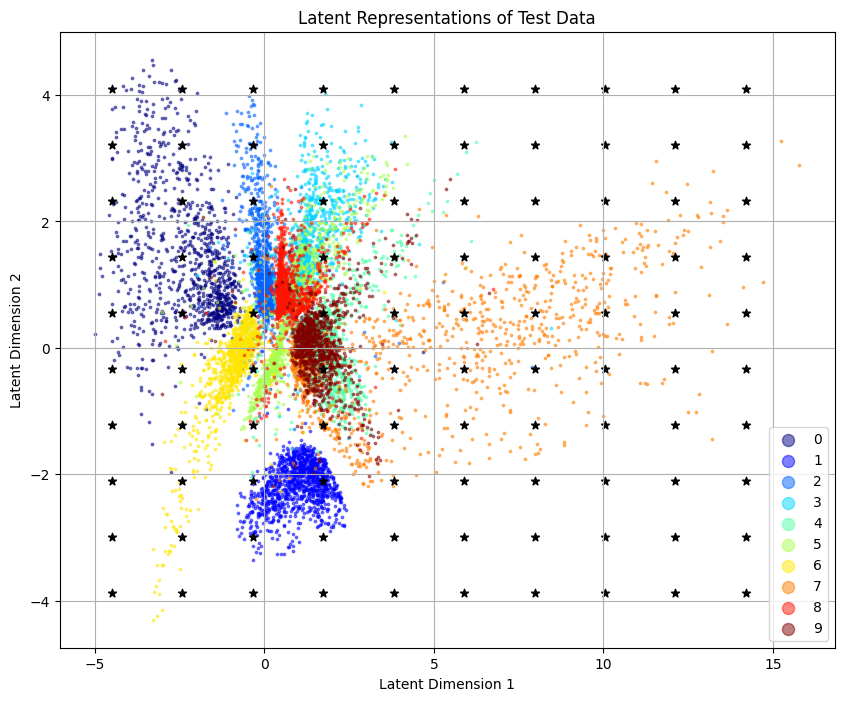

In [18]:
# Usaremos plot_griddots=True para exibir alguns pontos no nosso espaço latente
plot_latent_space(model.encoder, test_dataloader, plot_griddots=True, title='Latent Representations of Test Data')

Para cada ponto `(latent1, latent2)` representado pelas estrelas sobrepostas no plot do espaço latente 2D do conjunto de teste, iremos gerar a imagem que aquele ponto está codificando. O mapeamento será: imagem `(i, j)` corresponde à posição `(latent1, latent2)` no nosso espaço latente.

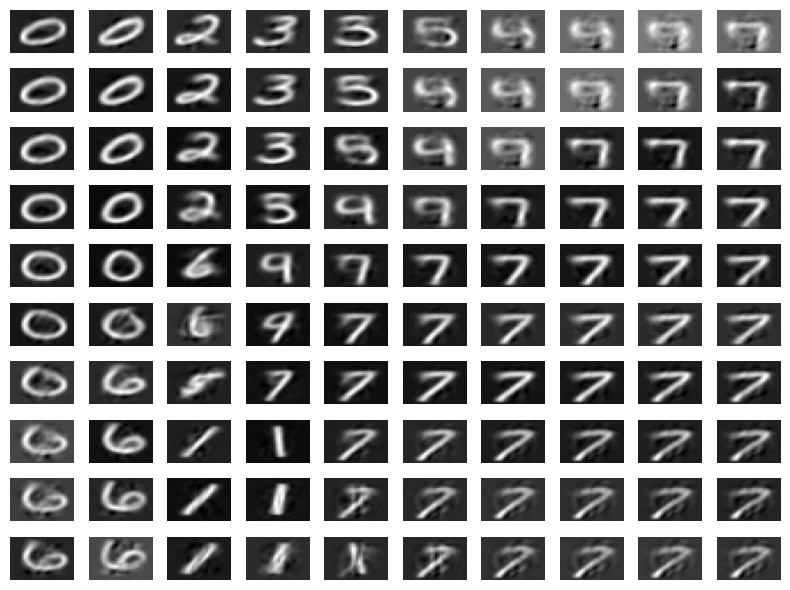

In [19]:
latent_representations, labels_agg = get_latent_representations(model.encoder, test_dataloader)

# Aqui iremos realizar o linspace do latent2 na direção max -> min para casar o plot com os pontos vistos acima
latent1_range = np.linspace(0.9 * latent_representations[:, 0].min(), 0.9 * latent_representations[:, 0].max(), num=10)
latent2_range = np.linspace(0.9 * latent_representations[:, 1].max(), 0.9 * latent_representations[:, 1].min(), num=10)

fig, axs = plt.subplots(10, 10, figsize=(8, 6))

model.decoder.eval()
with torch.no_grad():
    for i in range(10):
        for j in range(10):
            latent = torch.tensor([latent1_range[j], latent2_range[i]]).float()
            latent = latent.unsqueeze(0).to(device)  # adding batch size

            outputs = model.decoder(latent)
            axs[i, j].imshow(outputs.squeeze().cpu(), cmap='gray', aspect='auto')
            axs[i, j].axis('off')

fig.tight_layout()

Note que o _decoder_ gera imagens mesmo em regiões do nosso espaço latente que não possui nenhuma amostra mapeada. Na realidade, todo $\mathbb{R}^2$ está sendo mapeado pelo nosso AutoEncoder, e todo par $(x, y) \in \mathbb{R}^2$ terá uma decodificação associada. Observe como a decodificação fica ruidosa em regiões de transição de um grupo para o outro, como é o caso dos grupos do dígito 0 e 6, por exemplo.

Nesse exemplo, fizemos uma amostragem determinística dos pontos `(latent1, latent2)`. Porém, podemos adicionar um ruído gaussiano $\epsilon \sim N(0, \sigma^2)$, a cada uma das coordenadas, para gerar números diferentes de um mesmo grupo. Por enquanto, essa geração será muito "engessada", necessitando de uma análise do espaço latente e escolhas cuidadosas de um ponto central e valores para o $\sigma$. Isso ficará um pouco mais flexível com Variational AutoEncoders e outras técnicas subsequentes.

## **Desafio 3:** "Desembaraçamento" (_disentanglement_) do espaço latente

Como visto nos desafios anteriores, o nosso AutoEncoder funciona razoavelmente bem salvo algumas regiões onde há uma alta confusão de alguns dígitos, como é o caso do 4 e 9, 2 e 8, entre outros. Em casos como esses, várias ideias de "desembaraçamento", ou _disentanglement_, do espaço latente são utilizadas para tentar criar grupos mais espaçados.

Uma forma simples de tentarmos desembaraçar o nosso espaço latente é através de uma classificação raza (_shallow_) do dígito que queremos reconstruir a partir do espaço latente. Iremos modificar a nossa arquitetura e funções de treino para suportar uma classificação do dígito a partir do espaço latente.

In [20]:
class DisentangledAutoEncoderMLP(nn.Module):
    def __init__(self, img_size: int = 28, num_classes: int = 10):
        super().__init__()

        # Uma imagem do MNIST será 1 x 28 x 28
        num_features = 1 * img_size * img_size

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # nosso espaço latente estará em R²
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, num_features),  # recuperando as dimensões da imagem original
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))  # revertendo o flatten (784, ) -> (1, 28, 28)
        )

        self.classifier = nn.Linear(2, num_classes)

    def forward(self, x):
        latent = self.encoder(x)
        outputs = self.decoder(latent)
        class_preds = self.classifier(latent)

        return outputs, class_preds, latent

In [21]:
disentangled_model = DisentangledAutoEncoderMLP(img_size=28, num_classes=10)
disentangled_model = disentangled_model.to(device)

summary(disentangled_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 2]             130
            Linear-7                   [-1, 64]             192
              ReLU-8                   [-1, 64]               0
            Linear-9                  [-1, 128]           8,320
             ReLU-10                  [-1, 128]               0
           Linear-11                  [-1, 784]         101,136
        Unflatten-12            [-1, 1, 28, 28]               0
           Linear-13                   [-1, 10]              30
Total params: 218,544
Trainable params:

### Treinamento do modelo

Dado o caráter de reconstrução + predição das classes do nosso novo modelo, iremos definir a seguinte função de perda.

$$
\mathcal{L} = \alpha * \text{MSE}(x, \tilde{x}) + \beta * \text{CrossEntropy}(\text{clf}(z), y) + \gamma * |z|
$$

Sendo $x$ e $\tilde{x}$ a imagem de entrada e a sua reconstrução, $\alpha$, $\beta$ e $\gamma$ hiperparâmetros, $\text{clf}(z)$ a classificação da entrada a partir do espaço latente $z$ e $y$ o rótulo da entrada, $|z|$ uma regularização L1 do espaço latente, e respectivamente.

Para facilitar a escrita do código, iremos definir uma nova função de treino chamada `DisentangledLoss`. O restante do código permanecerá praticamente o mesmo.

In [22]:
class DisentangledLoss(nn.Module):
    def __init__(self, alpha: float = 1.0, beta: float = 1.0, gamma: float = 1.0):
        super().__init__()
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        self.l1 = nn.L1Loss()
        self.mse = nn.MSELoss(reduction='sum')
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, x, reconstructed_x, y_pred, y, latent):
        mse = self.mse(x, reconstructed_x) / x.size(0)
        cross_entropy = self.cross_entropy(y_pred, y)
        reg = self.l1(latent, torch.zeros_like(latent))

        loss = self.alpha * mse + self.beta * cross_entropy + self.gamma * reg
        return loss, (mse, cross_entropy, reg)

In [23]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print('Number of batches in train:', len(train_dataloader))
print('Number of batches in test:', len(test_dataloader))

Number of batches in train: 469
Number of batches in test: 79


In [24]:
# Redefinindo o modelo por praticidade
disentangled_model = DisentangledAutoEncoderMLP(img_size=28, num_classes=10)
disentangled_model = disentangled_model.to(device)

criterion = DisentangledLoss(beta=10.0)
optimizer = optim.Adam(disentangled_model.parameters(), lr=0.001)

In [25]:
def train_disentangled(model, optimizer, loss_fn, train_loader, val_loader=None, epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_regularization_loss = 0.0
        train_reconstruction_loss = 0.0
        train_classification_loss = 0.0

        for i, (inputs, labels) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            reconstructed_inputs, y_preds, latent = model(inputs)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            loss, (mse, cross_entropy, reg) = loss_fn(inputs, reconstructed_inputs, y_preds, labels, latent)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_regularization_loss += reg.item()
            train_reconstruction_loss += mse.item()
            train_classification_loss += cross_entropy.item()
            
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss/(i+1):.4f}")

        train_loss /= len(train_loader)
        train_regularization_loss /= len(train_loader)
        train_reconstruction_loss /= len(train_loader)
        train_classification_loss /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_reconstruction_loss = 0.0
            val_classification_loss = 0.0
            val_regularization_loss = 0.0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    reconstructed_inputs, y_preds, _ = model(inputs)
                    loss, (mse, cross_entropy, reg) = loss_fn(inputs, reconstructed_inputs, y_preds, labels, latent)

                    val_loss += loss.item()
                    val_regularization_loss += reg.item()
                    val_reconstruction_loss += mse.item()
                    val_classification_loss += cross_entropy.item()
            
            val_loss /= len(val_loader)
            val_regularization_loss /= len(val_loader)
            val_reconstruction_loss /= len(val_loader)
            val_classification_loss /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f'[Train] reconstruction loss: {train_reconstruction_loss:.4f} - classification loss: {train_classification_loss:.4f} - regularization loss: {train_regularization_loss:.4f}')
            print(f'[Validation] reconstruction loss: {val_reconstruction_loss:.4f} - classification loss: {val_classification_loss:.4f} - regularization loss: {val_regularization_loss:.4f}')
        else:
            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}")
            print(f'[Train] reconstruction loss: {train_reconstruction_loss:.4f} - classification loss: {train_classification_loss:.4f} - regularization loss: {train_regularization_loss:.4f}')

In [26]:
epochs = 20
train_disentangled(disentangled_model, optimizer, criterion, train_dataloader, test_dataloader, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: Train Loss: 58.6455 | Val Loss: 49.4410
[Train] reconstruction loss: 41.6951 - classification loss: 1.5215 - regularization loss: 1.7353
[Validation] reconstruction loss: 36.2389 - classification loss: 1.0678 - regularization loss: 2.5242


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: Train Loss: 47.2747 | Val Loss: 45.4793
[Train] reconstruction loss: 35.1310 - classification loss: 0.9625 - regularization loss: 2.5187
[Validation] reconstruction loss: 33.9752 - classification loss: 0.8889 - regularization loss: 2.6148


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: Train Loss: 44.2714 | Val Loss: 43.3850
[Train] reconstruction loss: 33.4351 - classification loss: 0.8314 - regularization loss: 2.5228
[Validation] reconstruction loss: 32.9418 - classification loss: 0.7997 - regularization loss: 2.4459


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: Train Loss: 42.5393 | Val Loss: 42.0224
[Train] reconstruction loss: 32.5666 - classification loss: 0.7524 - regularization loss: 2.4488
[Validation] reconstruction loss: 32.2786 - classification loss: 0.7389 - regularization loss: 2.3547


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: Train Loss: 41.2004 | Val Loss: 40.5243
[Train] reconstruction loss: 31.9571 - classification loss: 0.6840 - regularization loss: 2.4032
[Validation] reconstruction loss: 31.7483 - classification loss: 0.6736 - regularization loss: 2.0401


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: Train Loss: 40.1090 | Val Loss: 40.2648
[Train] reconstruction loss: 31.4869 - classification loss: 0.6264 - regularization loss: 2.3581
[Validation] reconstruction loss: 31.5286 - classification loss: 0.6172 - regularization loss: 2.5639


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: Train Loss: 39.2075 | Val Loss: 39.3074
[Train] reconstruction loss: 31.1393 - classification loss: 0.5740 - regularization loss: 2.3278
[Validation] reconstruction loss: 31.1770 - classification loss: 0.5702 - regularization loss: 2.4280


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: Train Loss: 38.4170 | Val Loss: 38.5936
[Train] reconstruction loss: 30.8366 - classification loss: 0.5279 - regularization loss: 2.3015
[Validation] reconstruction loss: 30.8105 - classification loss: 0.5306 - regularization loss: 2.4771


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: Train Loss: 37.7664 | Val Loss: 37.9923
[Train] reconstruction loss: 30.6310 - classification loss: 0.4862 - regularization loss: 2.2732
[Validation] reconstruction loss: 30.7242 - classification loss: 0.5099 - regularization loss: 2.1688


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: Train Loss: 37.1328 | Val Loss: 37.3152
[Train] reconstruction loss: 30.3971 - classification loss: 0.4486 - regularization loss: 2.2501
[Validation] reconstruction loss: 30.6527 - classification loss: 0.4673 - regularization loss: 1.9896


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: Train Loss: 36.5641 | Val Loss: 37.0935
[Train] reconstruction loss: 30.1740 - classification loss: 0.4164 - regularization loss: 2.2265
[Validation] reconstruction loss: 30.3993 - classification loss: 0.4416 - regularization loss: 2.2780


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: Train Loss: 36.0784 | Val Loss: 36.7910
[Train] reconstruction loss: 29.9752 - classification loss: 0.3913 - regularization loss: 2.1898
[Validation] reconstruction loss: 30.3598 - classification loss: 0.4302 - regularization loss: 2.1295


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: Train Loss: 35.6625 | Val Loss: 36.6426
[Train] reconstruction loss: 29.8143 - classification loss: 0.3695 - regularization loss: 2.1534
[Validation] reconstruction loss: 30.2214 - classification loss: 0.4160 - regularization loss: 2.2613


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: Train Loss: 35.2386 | Val Loss: 35.9499
[Train] reconstruction loss: 29.6052 - classification loss: 0.3519 - regularization loss: 2.1146
[Validation] reconstruction loss: 30.0040 - classification loss: 0.3989 - regularization loss: 1.9571


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: Train Loss: 34.8960 | Val Loss: 35.9935
[Train] reconstruction loss: 29.4748 - classification loss: 0.3342 - regularization loss: 2.0793
[Validation] reconstruction loss: 29.9795 - classification loss: 0.3857 - regularization loss: 2.1567


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: Train Loss: 34.5796 | Val Loss: 35.4911
[Train] reconstruction loss: 29.3913 - classification loss: 0.3144 - regularization loss: 2.0445
[Validation] reconstruction loss: 29.7668 - classification loss: 0.3774 - regularization loss: 1.9502


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: Train Loss: 34.2888 | Val Loss: 35.3162
[Train] reconstruction loss: 29.2761 - classification loss: 0.2996 - regularization loss: 2.0164
[Validation] reconstruction loss: 29.7264 - classification loss: 0.3616 - regularization loss: 1.9743


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: Train Loss: 33.9665 | Val Loss: 35.3690
[Train] reconstruction loss: 29.1166 - classification loss: 0.2861 - regularization loss: 1.9885
[Validation] reconstruction loss: 29.7195 - classification loss: 0.3583 - regularization loss: 2.0668


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: Train Loss: 33.7103 | Val Loss: 35.2436
[Train] reconstruction loss: 29.0127 - classification loss: 0.2737 - regularization loss: 1.9605
[Validation] reconstruction loss: 29.6934 - classification loss: 0.3543 - regularization loss: 2.0070


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: Train Loss: 33.4782 | Val Loss: 35.0242
[Train] reconstruction loss: 28.9396 - classification loss: 0.2610 - regularization loss: 1.9281
[Validation] reconstruction loss: 29.4881 - classification loss: 0.3490 - regularization loss: 2.0464


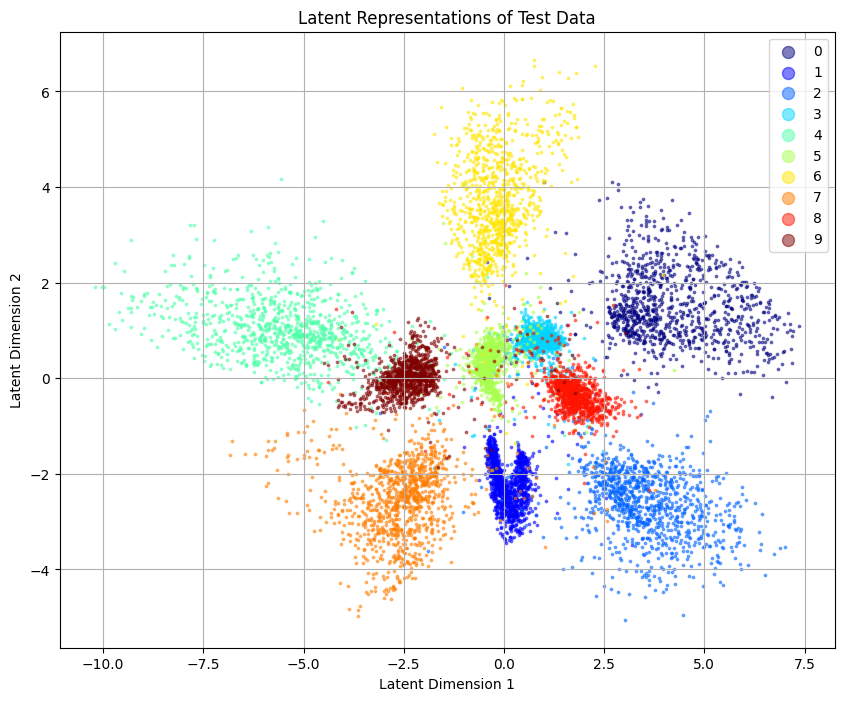

In [27]:
plot_latent_space(disentangled_model.encoder, test_dataloader, title='Latent Representations of Test Data')

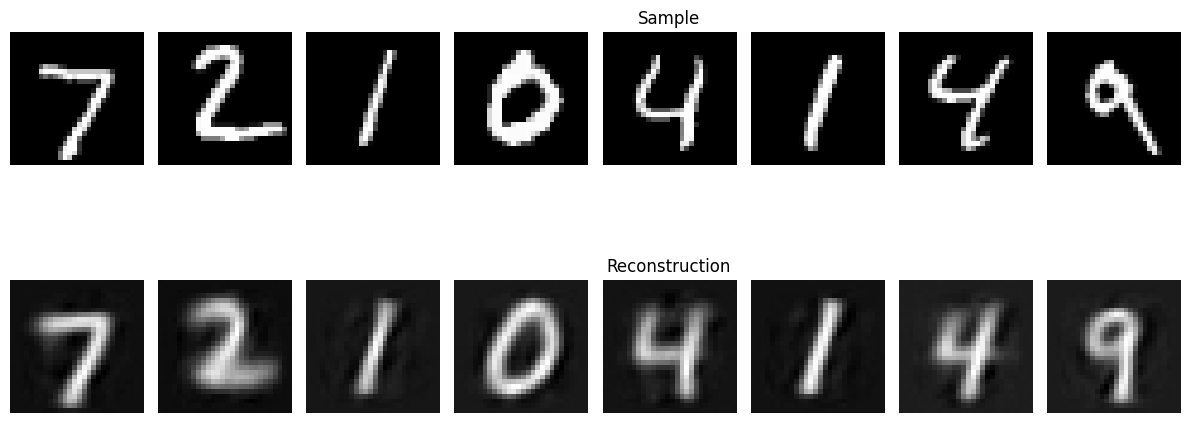

In [28]:
plot_reconstructions(disentangled_model, test_dataset)